Форма массива X_audio: (100, 5000)
Примеры меток (digits_audio): [1, 8, 0, 7, 9, 1, 8, 9, 7, 5]


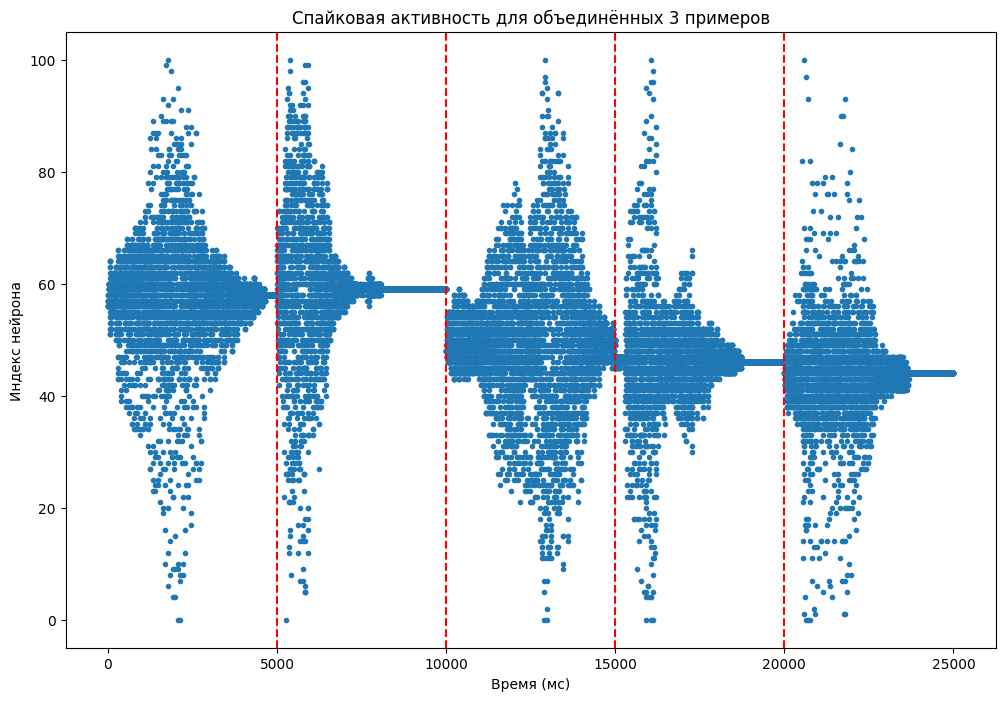

Форма восстановленного сигнала: (25000,)


Среднеквадратичная ошибка (MSE): 0.0002643511893277258
Коэффициент корреляции Пирсона: 0.9887844443385434


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import IPython.display as ipd
from brian2 import *
import librosa
import glob
import soundfile as sf

##############################################################################
# ФУНКЦИИ ДЛЯ ЗАГРУЗКИ И ПРЕДОБРАБОТКИ АУДИО
##############################################################################
def extract_useful_signal(signal, sr, top_db=20):
    """Обрезка тишины с начала и конца сигнала."""
    trimmed_signal, idx = librosa.effects.trim(signal, top_db=top_db)
    return trimmed_signal

def load_preprocess_audio(num_samples, target_length=5000):
    """
    Загрузка аудиофайлов, удаление тишины, нормировка в диапазон [0,1]
    и выравнивание длины до target_length с помощью усечения или дополнения нулями.
    """
    audio_files = glob.glob('free-spoken-digit-dataset/recordings/*.wav')
    np.random.shuffle(audio_files)
    selected_files = audio_files[:num_samples]
    
    X_audio_list = []
    sr_list = []
    digits_audio = []
    
    for file in selected_files:
        base_name = file.split('/')[-1]
        digit_str = base_name.split('_')[0]
        audio_digit = int(digit_str)
        digits_audio.append(audio_digit)
        
        signal, sr = librosa.load(file, sr=None)
        # Удаляем тишину слева и справа
        extract = extract_useful_signal(signal, sr, top_db=20)
        sr_list.append(sr)
        
        # Усечение или дополнение до target_length
        if len(extract) > target_length:
            signal = extract[:target_length]
        else:
            signal = np.pad(extract, (0, target_length - len(extract)), 'constant')
        
        # Масштабируем сигнал в диапазон [0,1]
        min_val, max_val = np.min(signal), np.max(signal)
        if max_val - min_val < 1e-12:
            signal = np.zeros_like(signal)
        else:
            signal = (signal - min_val) / (max_val - min_val)
        
        X_audio_list.append(signal)
    
    X_audio = np.array(X_audio_list)
    sr = sr_list[0] if sr_list else 22050

    unique_digits = np.unique(digits_audio)
    if len(unique_digits) < 2 and num_samples > 1:
        raise ValueError("Недостаточно разнообразных классов.")
    
    return X_audio, sr, digits_audio

##############################################################################
# ПАРАМЕТРЫ И ЗАГРУЗКА ДАННЫХ
##############################################################################
prefs.codegen.target = 'cython'
defaultclock.dt = 1*ms  # шаг интегрирования 1 мс

num_samples = 100
X_audio, sr, digits_audio = load_preprocess_audio(num_samples, target_length=5000)

print("Форма массива X_audio:", X_audio.shape)
print("Примеры меток (digits_audio):", digits_audio[:10])

# Параметры объединения примеров
num_examples = 5           # число примеров, которые будут объединены
target_length = 5000       # длительность одного примера (в отсчетах)
num_neurons = 101          # число нейронов (индексы 0..100)

##############################################################################
# ФОРМИРОВАНИЕ ОБЪЕДИНЁННОГО TIMEDARRAY
##############################################################################
# Для каждого из выбранных примеров создаём матрицу входного сигнала A размером (target_length x num_neurons)
# где в каждый момент времени t активируется нейрон с индексом, соответствующим значению аудио (после масштабирования).
A_list = []
for ex in range(num_examples):
    signal = X_audio[ex]
    # Преобразование сигнала в целочисленные индексы (умножаем на 100)
    audio_int = np.round(signal * 100, 2).astype(int)
    A = np.zeros((target_length, num_neurons))
    for t in range(target_length):
        neuron_idx = audio_int[t]
        A[t, neuron_idx] = 1.0
    A_list.append(A)

# Объединяем примеры по временной оси: итоговая матрица имеет размер (num_examples*target_length x num_neurons)
A_combined = np.concatenate(A_list, axis=0)
total_timesteps = A_combined.shape[0]

# Создаём TimedArray для всего объединённого сигнала
Audio_ext = TimedArray(A_combined, dt=1*ms)

##############################################################################
# ОПРЕДЕЛЕНИЕ МОДЕЛИ НЕЙРОНОВ
##############################################################################
tau = 10*ms
eqs = '''
dv/dt = (-v + Audio_ext(t,i))/tau : 1
'''

# Инициализация области моделирования
start_scope()

G = NeuronGroup(num_neurons, eqs,
                threshold='v > 0.05',
                reset='v = 0',
                method='euler')

# Настройка мониторинга спайков и состояний нейронов
spike_mon = SpikeMonitor(G)
state_mon = StateMonitor(G, 'v', record=True)

##############################################################################
# ЗАПУСК СИМУЛЯЦИИ
##############################################################################
run(total_timesteps * ms)

##############################################################################
# ВИЗУАЛИЗАЦИЯ СПАЙКОВ
##############################################################################
plt.figure(figsize=(12, 8))
plt.plot(spike_mon.t/ms, spike_mon.i, '.')
# Добавляем вертикальные линии для разделения примеров
for k in range(1, num_examples):
    plt.axvline(x=k*target_length, color='r', linestyle='--')
plt.xlabel('Время (мс)')
plt.ylabel('Индекс нейрона')
plt.title('Спайковая активность для объединённых 3 примеров')
plt.show()

##############################################################################
# ДЕКОДИРОВАНИЕ СИГНАЛА И СОХРАНЕНИЕ РЕЗУЛЬТАТОВ
##############################################################################
decoded_audio = np.zeros(total_timesteps)
# Преобразуем времена спайков в индексы дискретизации
times_in_ms = (spike_mon.t / ms).astype(int)
for idx in range(len(spike_mon.t)):
    t_spike = times_in_ms[idx]
    neuron_idx = spike_mon.i[idx]
    if 0 <= t_spike < total_timesteps:
        decoded_audio[t_spike] = neuron_idx

# Масштабируем декодированный сигнал обратно в диапазон [0,1]
reconstructed_signal = decoded_audio / 100.0
reconstructed_signal[reconstructed_signal == 0] = 0.5

print("Форма восстановленного сигнала:", reconstructed_signal.shape)

# Сохраняем объединённые оригинальный и декодированный сигналы
original_combined = np.concatenate([X_audio[i] for i in range(num_examples)])
sf.write('original_signal_combined.wav', original_combined, sr)
sf.write('decoded_sound_combined.wav', reconstructed_signal, samplerate=sr)

# Воспроизведение сигналов
display(ipd.Audio(original_combined, rate=sr))
display(ipd.Audio(reconstructed_signal, rate=sr))

# Вычисление среднеквадратичной ошибки (MSE)
mse = np.mean((original_combined - reconstructed_signal) ** 2)
print("Среднеквадратичная ошибка (MSE):", mse)

# Вычисление коэффициента корреляции Пирсона
corr_matrix = np.corrcoef(original_combined, reconstructed_signal)
pearson_corr = corr_matrix[0, 1]
print("Коэффициент корреляции Пирсона:", pearson_corr)